In [1]:
import glob
import json
import numpy as np
import os
import pickle
import torch

from detector import Detector
from parser import parse
from transformers import LxmertModel, LxmertTokenizer

PyTorch version 1.6.0 available.


In [2]:
def read_json(path='output.json'):
    """
    Check for valid JSON format and read content
    path: path to JSON file
    """
    file = open(path)
    line = file.read().replace('\n', ' ')
    file.close()
    try:
        parsed_json = json.loads(line)
    except:
        assert False, 'Invalid JSON'
    return parsed_json

def get_vid_ext(vid_id, video_dir):
    """
    Returns video file extension
    vid_id: video id
    video_dir: directory path to video files
    """
    vid_prefix = os.path.join(video_dir, vid_id)
    if os.path.exists(vid_prefix+'.mp4'):
        return '.mp4'
    elif os.path.exists(vid_prefix+'.mkv'):
        return '.mkv'
    elif os.path.exists(vid_prefix+'.webm'):
        return '.webm'
    

In [3]:
def download_video(vid_id, video_dir):
    """
    Download video
    vid_id: video id
    video_dir: directory path to video files
    """
    # download the video
    vid_url = 'www.youtube.com/watch?v='+vid_id
    vid_prefix = os.path.join(video_dir, vid_id) 
    os.system(' '.join(("youtube-dl -o", vid_prefix, vid_url)))


def sample_frames(vid_id, video_dir, frame_dir, fps=5):
    """
    Sample video into frames at fixed fps
    vid_id: video id
    video_dir: directory path to video files
    frame_dir: directory path to video frames
    fps: fps for frame extraction
    """
    if not os.path.isdir(os.path.join(frame_dir, vid_id)):
        os.mkdir(os.path.join(frame_dir, vid_id))
    vid_ext = get_vid_ext(vid_id, video_dir)
    ff_command = 'ffmpeg -i {}/{}{} -y -an -qscale 0 -vf fps={} {}/{}/%06d.jpg'.format(video_dir, vid_id, vid_ext, fps, frame_dir, vid_id)
    os.system(ff_command)


def remove_video(vid_id, video_dir):
    """
    Delete video
    vid_id: video id
    video_dir: directory path to video files
    """
    vid_prefix = os.path.join(video_dir, vid_id)
    vid_ext = get_vid_ext(vid_id, video_dir)
    os.remove(vid_prefix+vid_ext)


def select_frames(actions, vid_id, num_frames_per_step):
    """
    Returns representative frames for actions
    actions: list of action annotations from YCII annotations
    vid_id: video id
    num_frames_per_step: number of frames per action step
    Returns required_frames: set contataining names of representative frames
    """
    required_frames = set()
    for action in actions:
        action_start = action['segment'][0]
        action_end = action['segment'][1]
        action_delta = (action_end - action_start) / (num_frames_per_step + 1)    # need num_frames_per_step+1 intervals for num_frames_per_step inner frames
        for i in range(num_frames_per_step):
            frame_time = action_start + action_delta * (i+1)    # in seconds
            frame_id = int( frame_time*(num_frames_per_step + 1) )
            frame_name = '{}.jpg'.format(str(frame_id).zfill(6))
            required_frames.add(frame_name)
    return required_frames


def remove_frames(vid_id, frame_dir, required_frames):
    """
    Remove unused frames
    vid_id: video id
    frame_dir: directory path to video frames
    required_frames: set contataining names of representative frames
    """
    if os.path.isdir(os.path.join(frame_dir, vid_id)):
        curr_frames = os.listdir(os.path.join(frame_dir, vid_id))
        for frame in curr_frames:
            if frame not in required_frames:
                os.remove(os.path.join(frame_dir, vid_id, frame))


def get_actions(actions):
    """
    Returns list of actions text for video
    actions: list of action annotations from YCII annotations
    Returns actions_text: list of actions text for video
    """
    actions_text = []
    for action in actions:
        actions_text.append(action['sentence'])
    return actions_text


def pickle_data(data, pickles_dir, vid_id, fname):
    """
    Pickle data into bytestreams
    data: data to be pickled
    pickles_dir: directory path to pickled data
    vid_id: video id
    fname: name of pickled file
    """
    if not os.path.isdir(os.path.join(pickles_dir, vid_id)):
        os.mkdir(os.path.join(pickles_dir, vid_id))
    pickle_out = open(os.path.join(pickles_dir, vid_id, fname+'.pickle'), 'wb')
    pickle.dump(data, pickle_out)
    pickle_out.close()


def depickle_data(pickles_dir, vid_id, fname):
    """
    Depickle data from bytestreams
    pickles_dir: directory path to pickled data
    vid_id: video id
    fname: name of pickled file
    """
    pickle_path = os.path.join(pickles_dir, vid_id, fname+'.pickle')
    if os.path.exists(pickle_path):
        pickle_in = open(pickle_path, 'rb')
        candidates = pickle.load(pickle_in)
        return candidates
    return []



In [4]:
def prepare_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets', num_frames_per_step=4):
    """
    Download and prepare dataset files
    dataset_root: directory path to dataset base
    num_frames_per_step: number of frames per action step
    """

    annotations = read_json(os.path.join(dataset_root, 'annotations', 'ycii_annotations_trainval.json'))['database']
    
    videos_root = os.path.join(dataset_root, 'ycii_videos')
    if not os.path.isdir(videos_root):
        os.mkdir(videos_root)
    frames_root = os.path.join(dataset_root, 'ycii_frames')
    if not os.path.isdir(frames_root):
        os.mkdir(frames_root)
    pickles_root = os.path.join(dataset_root, 'ycii_pickles')
    if not os.path.isdir(pickles_root):
        os.mkdir(pickles_root)

    missing_vid_list = []

    detector = Detector()
    
    with open(os.path.join(dataset_root, 'vid_list', 'vid_list_ycii_val_short.txt')) as f:
        lines = f.readlines()
        for line in lines:
            rcp_type,vid_id = line.replace('\n','').split('/')
            print('[INFO] Processing video {}'.format(vid_id))
            
            # download the video
#             download_video(vid_id, videos_root)
            vid_url = 'www.youtube.com/watch?v='+vid_id
            vid_prefix = os.path.join(videos_root, vid_id) 
            os.system(' '.join(("youtube-dl -o", vid_prefix, vid_url)))

            # check if the video is available
            if os.path.exists(vid_prefix+'.mp4') or os.path.exists(vid_prefix+'.mkv') or os.path.exists(vid_prefix+'.webm'):
                print('[INFO] Downloaded video {}'.format(vid_id))
            else:
                missing_vid_list.append(line)
                print('[INFO] Cannot download video {}'.format(vid_id))
                continue

            # sample frames at fixed fps
            sample_frames(vid_id, videos_root, frames_root, fps=num_frames_per_step+1)
            print('[INFO] Sampled frames for video {}'.format(vid_id))

            # remove sampled video file (optional)
            remove_video(vid_id, videos_root)
            print('[INFO] Removed video {}'.format(vid_id))
            
            # select representative frames for actions
            actions = annotations[vid_id]['annotations']
            selected_frames = select_frames(actions, vid_id, num_frames_per_step)
            print('[INFO] Selected frames for video {}'.format(vid_id))

            # remove unsued frames
            remove_frames(vid_id, frames_root, selected_frames)
            print('[INFO] Removed unused frames for video {}'.format(vid_id))

            # get candidates for images
            frames = sorted(glob.glob(os.path.join(frames_root, vid_id, '*.*')))
            candidates = [detector.inference(frame, max_detections=5) for frame in frames]
            print('[INFO] Extracted candidates for video {}'.format(vid_id))

            # save pickeled files for candidates
            pickle_data(candidates, pickles_root, vid_id, 'candidates')
            print('[INFO] Saved candidates for video {}'.format(vid_id))
            
            # get annotations list
            actions_list = get_actions(actions)
            print('[INFO] Extracted actions for video {}'.format(vid_id))
            
            # save pickled files for annotations list
            pickle_data(actions_list, pickles_root, vid_id, 'actions')
            print('[INFO] Saved candidates for video {}'.format(vid_id))


    # write the missing videos to file
    missing_vid = open(os.path.join(dataset_root, 'vid_list', 'missing_videos.txt'), 'w')
    for line in missing_vid_list:
        missing_vid.write(line)

    # sanitize and remove the intermediate files
    # os.system("find {} -name '*.part*' -delete".format(dataset_root))
    os.system("find {} -name '*.f*' -delete".format(dataset_root))

In [5]:
def load_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets'):
    """
    Load dataset values from saved files
    dataset_root: directory path to dataset base
    """
    pickles_root = os.path.join(dataset_root, 'ycii_pickles')
    
    all_candidates = []
    all_actions = []
    with open(os.path.join(dataset_root, 'vid_list', 'vid_list_ycii_val_short.txt')) as f:
        lines = f.readlines()
        for line in lines:
            rcp_type,vid_id = line.replace('\n','').split('/')
            print('[INFO] Loading data for video {}'.format(vid_id))
            
            # load candidates data
            candidates = depickle_data(pickles_root, vid_id, 'candidates')
            if candidates:
                all_candidates.extend(candidates)
                print('[INFO] Loaded candidates for video {}'.format(vid_id))
            else:
                print('[INFO] Cannot load candidates for video {}'.format(vid_id))

            # load actions data
            actions = depickle_data(pickles_root, vid_id, 'actions')
            if actions:
                all_actions.append(actions)
                print('[INFO] Loaded actions for video {}'.format(vid_id))
            else:
                print('[INFO] Cannot load actions for video {}'.format(vid_id))

    return all_candidates, all_actions

In [ ]:
# USAGE: Run this just once to prepare and save data on disk
prepare_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets', num_frames_per_step=4)

In [6]:
# Required Cell

# USAGE: Run this to load all candidate and actions data from disk
all_candidates, all_actions = load_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets')

[INFO] Loading data for video sdB8qBlLS2E
[INFO] Cannot load candidates for video sdB8qBlLS2E
[INFO] Cannot load actions for video sdB8qBlLS2E
[INFO] Loading data for video fn9anlEL4FI
[INFO] Loaded candidates for video fn9anlEL4FI
[INFO] Loaded actions for video fn9anlEL4FI
[INFO] Loading data for video RnSl1LVrItI
[INFO] Loaded candidates for video RnSl1LVrItI
[INFO] Loaded actions for video RnSl1LVrItI
[INFO] Loading data for video vVZsj1t9R70
[INFO] Loaded candidates for video vVZsj1t9R70
[INFO] Loaded actions for video vVZsj1t9R70


In [7]:
# Required Cell
# Handles building steps and entity_count


# for actions in all_actions:
#     for i, action in enumerate(actions):
#         print(str(i) + ': ' + action)


# Strip all whitespaces and periods
# Note, periods will be added back later; need to temporarily remove periods before passing into parser
all_actions = [[action.strip('.') for action in actions] for actions in all_actions]

NULL = '[unused1]'
PAD = '[unused2]'
ENTITY = '[unused3]'
ACTION = '[SEP]'

# TODO: iterate through all annotations to find max_step_length
MAX_STEP_LENGTH = 30

tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased", pad_token=PAD)
tokenizer.add_special_tokens({"additional_special_tokens": [NULL, PAD, ENTITY]})
tokenizer.encode([NULL, PAD, ENTITY], add_special_tokens=True)

# TODO: iterate through all annotations to find max_step_length
max_step_length = 20    

entity_count = []
steps = []

for idx in range(len(all_actions)):
    
    entities, indices = parse(all_actions[idx], max_step_length=max_step_length)
    entities.append([NULL])
    entity_count.append([len(en) for en in entities])
    
    # insert in reverse so preceeding word indices can still be used for modified actions
    for ind in reversed(indices):
        action_idx = ind[0]//max_step_length
        entity_idx = ind[0]%max_step_length
        words = all_actions[idx][action_idx].split()
        words.insert(entity_idx, ENTITY)
        all_actions[idx][action_idx] = ' '.join(words)

        all_actions[idx] = [action + '.' if not action.endswith('.') else action for action in all_actions[idx]]

    tokens_steps = tokenizer(
                    all_actions[idx],
                    return_token_type_ids=False,
                    return_attention_mask=False,
                    add_special_tokens=True,
                    padding="max_length",
                    max_length=MAX_STEP_LENGTH + 2,
                    return_tensors="pt"
                )
    tokens_steps = tokens_steps['input_ids'].flatten()
    tokens_steps = tokens_steps[tokens_steps != 101]
    tokens_steps = tokenizer.decode(tokens_steps) + ' ' + NULL
    steps.append(tokens_steps)


# for actions in all_actions:
#     for i, action in enumerate(actions):
#         print(str(i) + ': ' + action)

In [8]:
# Required Cell
# Handles building boxes and features


# Reshape all of the candidate bounding box and feature tensors.
boxes = torch.tensor([candidate[0].numpy() for candidate in all_candidates]).squeeze(1)
features = torch.tensor([candidate[1].numpy() for candidate in all_candidates]).squeeze(1)

boxes = boxes.flatten(start_dim=0, end_dim=1)
features = features.flatten(start_dim=0, end_dim=1)

boxes = torch.stack((boxes, boxes))
features = torch.stack((features, features))

In [9]:
print(steps)

['add [unused3] garram masala seeds and a bay leaf to [unused3] the oil. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] add [unused3] the lamb to [unused3] the pot. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] add [unused3] garlic ginger paste and chopped onions to the pot. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] add [unused3] chili tumeric coriander cumin and salt. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] add [unused3] water to [unused3] the pot. [SEP] [

In [10]:
print(features)

tensor([[[1.7991e-01, 0.0000e+00, 7.0093e-03,  ..., 0.0000e+00,
          1.4755e-01, 0.0000e+00],
         [2.2051e-01, 3.1070e-02, 0.0000e+00,  ..., 0.0000e+00,
          1.4792e-01, 4.2602e-02],
         [2.0538e-01, 0.0000e+00, 5.4833e-01,  ..., 1.1816e-03,
          1.5883e+00, 1.1352e-01],
         ...,
         [1.8698e-03, 1.1624e-01, 0.0000e+00,  ..., 2.6708e-02,
          9.0285e-01, 0.0000e+00],
         [0.0000e+00, 1.2186e-02, 1.5609e-03,  ..., 0.0000e+00,
          6.3553e-01, 3.0597e-01],
         [0.0000e+00, 6.0014e-02, 2.3838e-01,  ..., 0.0000e+00,
          3.5569e-01, 2.7256e-01]],

        [[1.7991e-01, 0.0000e+00, 7.0093e-03,  ..., 0.0000e+00,
          1.4755e-01, 0.0000e+00],
         [2.2051e-01, 3.1070e-02, 0.0000e+00,  ..., 0.0000e+00,
          1.4792e-01, 4.2602e-02],
         [2.0538e-01, 0.0000e+00, 5.4833e-01,  ..., 1.1816e-03,
          1.5883e+00, 1.1352e-01],
         ...,
         [1.8698e-03, 1.1624e-01, 0.0000e+00,  ..., 2.6708e-02,
          9.028

In [11]:
print(boxes)

tensor([[[0.8246, 0.0321, 1.0000, 0.9723],
         [0.2761, 0.2671, 0.9179, 0.9007],
         [0.0240, 0.0064, 0.3408, 0.8375],
         ...,
         [0.5325, 0.1385, 0.9986, 0.8754],
         [0.1927, 0.2561, 0.8114, 0.9569],
         [0.3112, 0.1517, 0.7429, 0.8573]],

        [[0.8246, 0.0321, 1.0000, 0.9723],
         [0.2761, 0.2671, 0.9179, 0.9007],
         [0.0240, 0.0064, 0.3408, 0.8375],
         ...,
         [0.5325, 0.1385, 0.9986, 0.8754],
         [0.1927, 0.2561, 0.8114, 0.9569],
         [0.3112, 0.1517, 0.7429, 0.8573]]])


In [12]:
print(entity_count)

[[2, 2, 1, 1, 2, 2, 2, 2, 1], [3, 2, 2, 2, 1, 2, 1, 2, 1], [2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1]]


In [13]:
%matplotlib inline

In [14]:
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

In [37]:
def get_first_frame(action_id, action_start, action_end, num_frames_per_step):
    """
    Returns first frame name of a given action, and time delay into the segment when the frame appears (in sec)
    action_id: id of action within video
    action_start: start time (in sec) of action
    action_end: end time (in sec) of action
    num_frames_per_step: number of frames per action step
    Returns frame_name: name of first frame for an action
    Returns action_delta: time delay into the segment when the frame appears (in sec)
    """
    action_delta = (action_end - action_start) / (num_frames_per_step + 1)    # need num_frames_per_step+1 intervals for num_frames_per_step inner frames
    frame_time = action_start + action_delta    # in seconds
    frame_id = int( frame_time*(num_frames_per_step + 1) )
    frame_name = '{}.jpg'.format(str(frame_id).zfill(6))
    return frame_name, action_delta

In [48]:
def visualize_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets', num_frames_per_step=4):
    """
    Visualize the first frame of each step in dataset videos
    dataset_root: directory path to dataset base
    num_frames_per_step: number of frames per action step
    """

    vids_list = os.listdir(os.path.join(dataset_root, 'ycii_frames'))
    annotations_bb_all = read_json(os.path.join(dataset_root, 'yc2_bb/annotations', 'yc2_bb_val_annotations.json'))['database']
    
    detector = Detector()
#     visualize_candidates = []
    
    for vid_id in vids_list[:1]:
        print('vid_id: ' + vid_id)

        annotations_bb_vid = annotations_bb_all[vid_id]
        vid_segments = annotations_bb_vid['segments']

        annot_width = annotations_bb_vid['rwidth']
        annot_height = annotations_bb_vid['rheight']
        print('annotated image size: ' + str(annot_width) + ', ' + str(annot_height))

        for segment_id in sorted(vid_segments):
#             print(segment_id)    # 'segment_id'th segment of the video 'vid_id'
#             print(vid_segments[segment_id]['segment'])    # displays start and end time (in sec) of the segment

            frame_name, segment_delta = get_first_frame(segment_id, vid_segments[segment_id]['segment'][0], vid_segments[segment_id]['segment'][1], num_frames_per_step)
            print('frame_name: ' + frame_name)
            segment_frame_id = int(round(segment_delta))
            
            # read the image from disk
            img = Image.open(os.path.join(dataset_root, 'ycii_frames', vid_id, frame_name))

            # get saved image dimensions
            saved_width = img.size[0]
            saved_height = img.size[1]
            print('saved image size: ' + str(saved_width) + ', ' + str(saved_height))
            
            # create figure and axes
            fig, ax = plt.subplots()
            
            # display the image on the plot
            ax.imshow(img)

            # add ground truth bounding boxes
            for entity in vid_segments[segment_id]['objects']:
                label = entity['label']
                bboxes = entity['boxes']
                bbox = bboxes[segment_frame_id]
                
                if (bbox['occluded']==1):
                    continue
                
#                 print(bbox) 
                print('label: ' + label)
                
                left = int(bbox['xtl'] / annot_width * saved_width)
                top = int(bbox['ytl'] / annot_height * saved_height)
                width = int( (bbox['xbr'] - bbox['xtl']) / annot_width * saved_width)
                height = int( (bbox['ybr'] - bbox['ytl']) / annot_height * saved_height)
                

                # Create a Rectangle patch ( (x, y), width, height )
                rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='g', facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect)
            
            
            # get candidates for images
            candidates = detector.inference(os.path.join(dataset_root, 'ycii_frames', vid_id, frame_name), max_detections=10)
#             print(candidates)
#             visualize_candidates.append(candidates)
            boxes = torch.tensor([candidates[0].numpy()]).squeeze(1)
            boxes = boxes.flatten(start_dim=0, end_dim=1)
            boxes = boxes.numpy().tolist()
            
            # add detector candidate bounding boxes
            for candidate_box in boxes:
                print(candidate_box)
                
                left = int(round(candidate_box[0] * saved_width))
                top = int(round(candidate_box[1] * saved_height))
                width = int( ( candidate_box[2] - candidate_box[0] ) * saved_width )
                height = int( ( candidate_box[3] - candidate_box[1] ) * saved_height )
                
                # Create a Rectangle patch ( (x, y), width, height )
                rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect)

            # display the plot
            plt.show()
#             return visualize_candidates



loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /h/mkhan/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
vid_id: fn9anlEL4FI
annotated image size: 720, 405
frame_name: 000159.jpg
saved image size: 1280, 720
label: oil
[0.82457035779953, 0.03210151940584183, 1.0, 0.9723386764526367]
[0.27612778544425964, 0.2670735716819763, 0.917853832244873, 0.9007272720336914]
[0.024002818390727043, 0.006386433728039265, 0.3408110439777374, 0.8374579548835754]
[0.567914

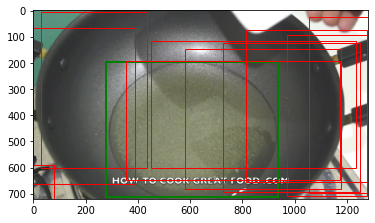

frame_name: 000362.jpg
saved image size: 1280, 720
label: pot
[0.22894199192523956, 0.17582610249519348, 0.6362505555152893, 0.7930307388305664]
[0.1894836723804474, 0.2881008982658386, 0.6178411245346069, 0.9132331609725952]
[0.14150598645210266, 0.31923556327819824, 0.5617164373397827, 0.9897529482841492]
[0.2781725823879242, 0.4223746061325073, 0.7461551427841187, 0.9917513728141785]
[0.3372403085231781, 0.31425076723098755, 0.7781822085380554, 0.9611986875534058]
[0.5953620672225952, 0.14088773727416992, 0.9803932905197144, 0.9532605409622192]
[0.802432656288147, 0.01915767416357994, 0.999775230884552, 0.968284547328949]
[0.0010667301248759031, 0.07204695045948029, 0.32197144627571106, 0.931395947933197]
[0.0, 0.10287841409444809, 0.4527248442173004, 0.8978292942047119]
[0.20968076586723328, 0.4158286154270172, 0.6525441408157349, 0.9911665916442871]


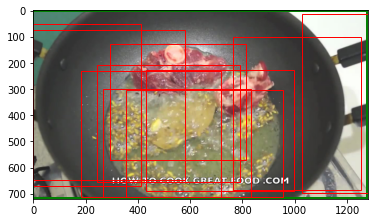

frame_name: 000693.jpg
saved image size: 1280, 720
label: onions
label: pot
[0.4352286458015442, 0.4926946461200714, 0.8531485795974731, 0.996033787727356]
[0.35054662823677063, 0.011916869319975376, 0.746521532535553, 0.6314501762390137]
[0.11301968991756439, 0.08017639070749283, 0.7040389776229858, 0.7825186848640442]
[0.12471494823694229, 0.02921293117105961, 0.4467548429965973, 0.8037576675415039]
[0.17819413542747498, 0.015992043539881706, 0.5978306531906128, 0.6093122959136963]
[0.4141171872615814, 0.3315974771976471, 0.838570773601532, 0.993241012096405]
[0.2596544325351715, 0.0792386457324028, 0.8724023699760437, 0.760898768901825]
[0.28016263246536255, 0.014168111607432365, 0.684053361415863, 0.6077598333358765]
[0.48208826780319214, 0.17955172061920166, 0.8831822276115417, 0.8748407959938049]
[0.22469203174114227, 0.05548905208706856, 0.7368982434272766, 0.6486861109733582]


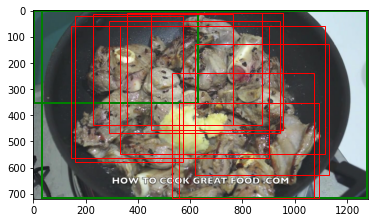

frame_name: 000863.jpg
saved image size: 1280, 720
label: salt
[0.1424199640750885, 0.006954548880457878, 0.5052431225776672, 0.9423187971115112]
[0.06654176115989685, 0.012163858860731125, 0.4862877428531647, 0.778437614440918]
[0.09932615607976913, 0.07882601022720337, 0.6524072289466858, 0.7627131938934326]
[0.13044729828834534, 0.18591119349002838, 0.6947791576385498, 0.8447884321212769]
[0.06142188236117363, 0.00984236691147089, 0.6123260259628296, 0.6501244306564331]
[0.11519014835357666, 0.2037607878446579, 0.539211630821228, 0.8829190731048584]
[0.23361404240131378, 0.16037617623806, 0.8255793452262878, 0.8445408344268799]
[0.1061297208070755, 0.31490880250930786, 0.6767408847808838, 0.9474207758903503]
[0.1800977885723114, 0.2560010254383087, 0.7501004934310913, 0.9029665589332581]
[0.14655688405036926, 0.0012713216710835695, 0.7430008053779602, 0.6674541234970093]


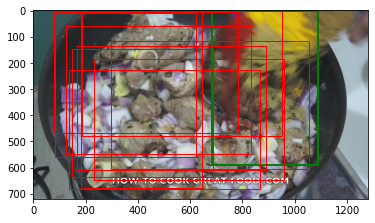

frame_name: 001158.jpg
saved image size: 1280, 720
label: water
label: pot
[0.35454902052879333, 0.31656086444854736, 0.816195011138916, 0.92057865858078]
[0.41741305589675903, 0.5357781648635864, 0.8503427505493164, 0.9933308959007263]
[0.05391426011919975, 0.09527068585157394, 0.47311607003211975, 0.7546892762184143]
[0.24572809040546417, 0.12036478519439697, 0.6981981992721558, 0.8182176947593689]
[0.11323988437652588, 0.0791434720158577, 0.5383924245834351, 0.7897440791130066]
[0.315409779548645, 0.3891318440437317, 0.7668896913528442, 0.9901450276374817]
[0.4896954596042633, 0.3390539586544037, 0.9073529243469238, 0.9911420941352844]
[0.415743350982666, 0.14761489629745483, 0.8528478741645813, 0.851438581943512]
[0.171441912651062, 0.1068427711725235, 0.623278021812439, 0.8003569841384888]
[0.18244338035583496, 0.01516501884907484, 0.6232605576515198, 0.6044653058052063]


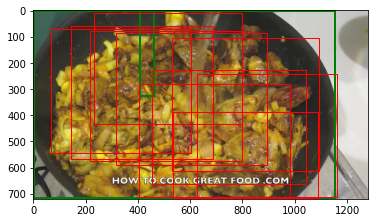

frame_name: 001569.jpg
saved image size: 1280, 720
label: pot
[0.33951976895332336, 0.12390477955341339, 0.5602192282676697, 0.5234586596488953]
[0.05211024358868599, 0.13496918976306915, 0.45355382561683655, 0.8613550066947937]
[0.08716469258069992, 0.05121203511953354, 0.4146440923213959, 0.9319428205490112]
[0.18488697707653046, 0.13130171597003937, 0.6176708340644836, 0.8441431522369385]
[0.10527465492486954, 0.04793981835246086, 0.5009995698928833, 0.7350714206695557]
[0.27679237723350525, 0.01312058512121439, 0.6544203162193298, 0.688857913017273]
[0.06448721140623093, 0.25197634100914, 0.47682303190231323, 0.9769745469093323]
[0.09920131415128708, 0.17969343066215515, 0.5233721733093262, 0.9107445478439331]
[0.17586001753807068, 0.0077667236328125, 0.5935360193252563, 0.5481832027435303]
[0.29319244623184204, 0.06351891905069351, 0.6201549172401428, 0.9593543410301208]


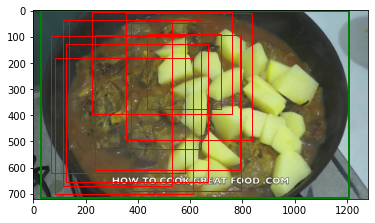

frame_name: 001922.jpg
saved image size: 1280, 720
label: pot
[0.0008076397934928536, 0.3778172731399536, 0.26813554763793945, 0.9960516095161438]
[0.006733739282935858, 0.6574977040290833, 0.38625454902648926, 0.9995809197425842]
[0.0038962685503065586, 0.010802632197737694, 0.3588762879371643, 0.5654809474945068]
[0.15003056824207306, 0.1528419852256775, 0.44831785559654236, 0.9844130873680115]
[0.07936438173055649, 0.020140420645475388, 0.45244717597961426, 0.7197526097297668]
[0.0, 0.11751440167427063, 0.2545703053474426, 0.9025242924690247]
[0.3392263352870941, 0.10876188427209854, 0.7326098084449768, 0.8407658934593201]
[0.019205104559659958, 0.25885215401649475, 0.4009994566440582, 0.9375126361846924]
[0.0, 0.2735554575920105, 0.1768777072429657, 0.9915323853492737]
[0.6089723110198975, 0.23971593379974365, 0.8577855825424194, 0.9861459732055664]


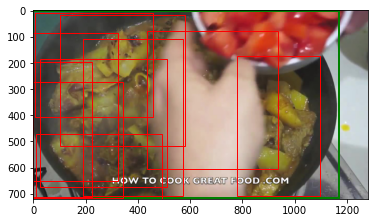

frame_name: 002195.jpg
saved image size: 1280, 720
label: pot
[0.5066750049591064, 0.10753332823514938, 0.726405680179596, 0.5217782855033875]
[0.002084593288600445, 0.3933383822441101, 0.3755267262458801, 0.995589554309845]
[0.06384847313165665, 0.058821938931941986, 0.4806686341762543, 0.7750067710876465]
[0.10986689478158951, 0.1683671772480011, 0.5334460735321045, 0.8232600092887878]
[0.00047185487346723676, 0.20346981287002563, 0.3576852083206177, 0.9065787196159363]
[0.049087490886449814, 0.0790829211473465, 0.3867291808128357, 0.965944230556488]
[0.09666693955659866, 0.30936384201049805, 0.5082990527153015, 0.989016056060791]
[0.5465890765190125, 0.1935514658689499, 0.9665129780769348, 0.941034197807312]
[0.0024750602897256613, 0.2965773940086365, 0.449556440114975, 0.9761219620704651]
[0.00304662948474288, 0.431618869304657, 0.5218862295150757, 0.9932624101638794]


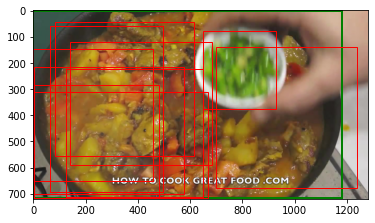

In [49]:
# Optional Cell
# USAGE: Run this to display first frame of each step in dataset videos
visualize_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets', num_frames_per_step=4)
# candidates = visualize_dataset(dataset_root='/h/mkhan/ece496-capstone/datasets', num_frames_per_step=4)

In [ ]:
# NOTE: Do not execute the cells below, they are rough code for testing stuff out

In [ ]:
print(boxes.size())
print(features.size())

In [ ]:
for vid in os.listdir(os.path.join('/h/mkhan/ece496-capstone/datasets/ycii_frames/', '')):
    print(os.listdir(os.path.join('/h/mkhan/ece496-capstone/datasets/ycii_frames/', vid)))
    print('\n')

In [ ]:
8+11+8

In [ ]:
import collections

dataset_root = '/h/mkhan/ece496-capstone/datasets'
annotations = read_json(os.path.join(dataset_root, 'annotations', 'ycii_annotations_trainval.json'))['database']
max_len = 0
min_len = 1000
actions_lenths = []
steps_lenths = []
vid_count = 0
min_duration = 100

with open(os.path.join(dataset_root, 'vid_list', 'vid_list_ycii_train.txt')) as f:
    lines = f.readlines()
    for line in lines:
        rcp_type,vid_id = line.replace('\n','').split('/')
#         print('[INFO] Processing video {}'.format(vid_id))
        actions = annotations[vid_id]['annotations']
        actions_lenths.append(len(actions))
        for action in actions:
#             print(len(action['sentence'].split()))
            steps_lenths.append(len(action['sentence'].split()))
            
#         print(actions[0]['segment'])
#         print()
        if min_duration > actions[0]['segment'][1] - actions[0]['segment'][0]:
            min_duration = actions[0]['segment'][1] - actions[0]['segment'][0]
        
#         print(len(actions))
        if max_len < len(actions):
            max_len = len(actions)
        if min_len > len(actions):
            min_len = len(actions)
        vid_count += 1

# print(max_len)

# arr = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 5, 5] 
freq = collections.Counter(actions_lenths)
word_len_freq = collections.Counter(steps_lenths)
# print(freq)

for key in sorted(freq):
    print("%s: %s" % (key, freq[key]))
print('\n')
for key in sorted(word_len_freq):
    print("%s: %s" % (key, word_len_freq[key]))

print('# of Videos: ' + str(vid_count))
print('Max step count: ' + str(max_len))
print('Min step count: ' + str(min_len))
print('Min step duration: ' + str(min_duration))


In [ ]:
# img = mpimg.imread('/h/mkhan/ece496-capstone/datasets/ycii_frames/fn9anlEL4FI/000069.jpg')

In [ ]:
# imgplot = plt.imshow(img)

In [ ]:
img = Image.open('/h/mkhan/ece496-capstone/datasets/ycii_frames/fn9anlEL4FI/000159.jpg')

In [ ]:

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
# print(boxes.size())
# print(boxes[0].size())
print(boxes[0][0])

In [ ]:
dataset_root = '/h/mkhan/ece496-capstone/datasets/'

annotations = read_json(os.path.join(dataset_root, 'annotations', 'ycii_annotations_trainval.json'))['database']
print(annotations['fn9anlEL4FI'])

In [ ]:
dataset_root = '/h/mkhan/ece496-capstone/datasets'
annotations_bb = read_json(os.path.join(dataset_root, 'yc2_bb/annotations', 'yc2_bb_val_annotations.json'))['database']
# print(annotations_bb['fn9anlEL4FI'])
# for key in annotations_bb:
#     print(key)

sample_vid = annotations_bb['fn9anlEL4FI']
for key in sample_vid:
    print(key)


In [ ]:
# for key in sorted(sample_vid['segments']):
#     print(sample_vid['segments'][key])

sample_segment = sample_vid['segments']['1']

print(sample_segment['segment'])

# for key in sorted(sample_segment):
#     print(key)

# print(sample_segment['objects'][0])
# for key in sorted(sample_segment['objects'][0]):
#     print(key)

# print(sample_segment['objects'][0]['label'])
# print(sample_segment['objects'][0]['boxes'])
for bbox in sample_segment['objects'][0]['boxes']:
    print(bbox)


In [ ]:
# NOTE: Do not execute the cells below, they are rough code for testing stuff out

In [ ]:
# print(all_actions)

for actions in all_actions:
    for action in actions:
        print(action)
# actions = all_actions[0]
# print(actions)
# actions = [action + '.' if not action.endswith('.') else action for action in actions]
# print(actions)

# print(all_actions)
for actions in all_actions:
    for action in actions:
        print(action)


# for actions in all_actions:
#     for action in actions:
# #         print(action)
#         if not action.endswith('.'):
#             action += '.'

# print(all_actions)

In [ ]:
# Ensure all actions terminate with periods (Note, make sure NULL action is not yet added to actions lists)
# all_actions = [[action + '.' if not action.endswith('.') else action for action in actions] for actions in all_actions]

In [ ]:

idx = 0
# print(all_actions[idx])
print(all_actions[idx][0])
words = all_actions[idx][0].split()
print(words)

indices = [[1, 2, 3], [9, 10]]

for ind in reversed(indices):
    print(ind[0])
    words.insert(ind[0], '[unused3]')

all_actions[idx][0] = ' '.join(words)
print(all_actions[idx][0])

# sentence = 'add  garram masala seeds and a bay leaf to the oil.'
# print(sentence)
# words = sentence.split()
# print(words)



In [ ]:
# print(all_actions)

steps = all_actions[0]
steps1 = [step.strip() for step in steps]

# print(steps)
# print(steps1)
for s in steps1:
    print(s)


In [ ]:
entities, indices = parse(steps, max_step_length=20)
entities.append([NULL])

In [ ]:
print(len(steps))
print(len(entities))
print(len(indices))

print(steps)
print(entities)
print(indices)

In [ ]:
# entities.append(NULL)
ent_len = [len(e) for e in entities]
# ent_len.append(1)    # For appened NULL (alternatively, do entities.append(null))
print(ent_len)

In [ ]:
steps1 = []
steps1.append('Grill [unused3] the tomatoes in [unused3] a pan.')
steps1.append('Add [unused3] oil into [unused3] the pan.')
steps1.append('Add [unused3] oil into [unused3] the pan.')
steps1.append('Cook [unused3] the bacon.')
steps1.append('Spread [unused3] some mayonnaise onto [unused3] the bread.')
steps1.append('Place [unused3] a piece of [unused3] lettuce onto [unused3] it.')
steps1.append('Place [unused3] the tomatoes over [unused3] it.')
steps1.append('Sprinkle [unused3] some salt and pepper onto [unused3] it.')
steps1.append('Place [unused3] the bacon at [unused3] the top.')
steps1.append('Place the [unused3] piece of bread at the top.')


In [ ]:
NULL = '[unused1]'
PAD = '[unused2]'
ENTITY = '[unused3]'
ACTION = '[SEP]'

MAX_STEP_LENGTH = 30

In [ ]:
from transformers import LxmertModel, LxmertTokenizer

tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased", pad_token=PAD)
tokenizer.add_special_tokens({"additional_special_tokens": [NULL, PAD, ENTITY]})
tokenizer.encode([NULL, PAD, ENTITY], add_special_tokens=True)

tokens_steps1 = tokenizer(
                    steps1,
                    return_token_type_ids=False,
                    return_attention_mask=False,
                    add_special_tokens=True,
                    padding="max_length",
                    max_length=MAX_STEP_LENGTH + 2,
                    return_tensors="pt"
                )


In [ ]:
print(tokens_steps1['input_ids'])

In [ ]:
steps1_flat = tokens_steps1['input_ids'].flatten()
# print(steps1_flat)
steps1_flat = steps1_flat[steps1_flat != 101]
# print(steps1_flat)
steps1_flat = tokenizer.decode(steps1_flat) + ' ' + NULL
print(steps1_flat)

In [ ]:
asdf = 'hello'
qwer = 'world'
print(type([asdf,qwer]))


In [ ]:
print(steps1_flat)

In [ ]:
# print(tokens_steps1['input_ids'])

steps1_flat = tokens_steps1['input_ids'].flatten()
print(steps1_flat)
steps1_flat = steps1_flat[steps1_flat != 101]
print(steps1_flat)


In [ ]:
annotations = read_json(os.path.join('/h/mkhan/ece496-capstone/datasets', 'annotations', 'ycii_annotations_trainval.json'))['database']

In [ ]:
actions = annotations['fn9anlEL4FI']['annotations']

In [ ]:
print(actions)

In [ ]:
i = 0
for item in annotations:
    if annotations[item]['subset']=='validation':
        print(item)
#         print(annotations[item])
        print(annotations[item]['duration'])
#         print(annotations[item]['annotations'])
        segments = annotations[item]['annotations']
        for segment in segments:
            print(segment)
#             start = segment['segment'][0]
            end = segment['segment'][1]
#             print(str(start) + " " + str(end))
        
        print(end)

        i += 1
        if i==3:
            break